In [2]:
import pandas as pd
import numpy as np
performance_df=pd.read_parquet("performance_RF_with_index.parquet",engine='fastparquet')
performance_df

FileNotFoundError: [Errno 2] No such file or directory: 'performance_RF_with_index.parquet'

In [18]:
df_rfmonth=pd.read_excel("CH4_factors_monthly.xlsx",engine='openpyxl')
df_rfmonth.rename(columns={'mnthdt':'date'},inplace=True)
df_rfmonth['date'] = pd.to_datetime(df_rfmonth['date'].astype(str))
df_rfmonth = df_rfmonth.set_index('date')
df_rfmonth.index = df_rfmonth.index.to_period('M').to_timestamp()
df_rfmonth

,rf_mon,mktrf,VMG,SMB,PMO
date,,,,,
2000-01-01,0.0019,0.1479,-0.0084,-0.0188,-0.1090
2000-02-01,0.0018,0.1197,-0.0728,0.0165,-0.0127
2000-03-01,0.0019,0.0432,-0.0050,0.0785,0.0793
2000-04-01,0.0018,0.0168,0.0243,-0.0056,0.0278
2000-05-01,0.0019,0.0220,0.0206,0.0185,-0.0093
...,...,...,...,...,...
2025-06-01,0.0012,0.0391,-0.0219,0.0228,0.0203
2025-07-01,0.0013,0.0444,0.0003,-0.0005,-0.0056
2025-08-01,0.0013,0.0981,-0.0540,-0.0413,0.0218


In [19]:
import pandas as pd
import numpy as np
from scipy import stats

# ==========================================
# 1. 数据对齐与合并 (Data Alignment)
# ==========================================
# 确保 performance_df 的索引也是 datetime 格式，并归一化到月初，以便与 df_rfmonth 对齐
# 假设 performance_df 的索引已经是日期，如果不是（例如是列），请先 set_index
if 'date' in performance_df.columns:
    performance_df = performance_df.set_index('date')
    
performance_df.index = pd.to_datetime(performance_df.index)
# 强制将策略收益的日期也转为“月初”，确保能匹配上 df_rfmonth (它已经是 MonthBegin)
performance_df.index = performance_df.index.to_period('M').to_timestamp()

# 合并数据：只取交集部分 (join='inner')
# 我们只需要 rf_mon (无风险利率)
df_merged = performance_df.join(df_rfmonth[['rf_mon']], how='inner')

print(f"数据合并完成。时间范围: {df_merged.index[0].date()} 至 {df_merged.index[-1].date()}")
print(f"样本量: {len(df_merged)} 个月")

# ==========================================
# 2. 计算超额收益 (Excess Returns)
# ==========================================
# 定义需要计算的策略列名
strategy_cols = ['EW_Long', 'EW_Short', 'EW_Strategy', 'VW_Long', 'VW_Short', 'VW_Strategy']
# 确保这些列在数据中存在
valid_cols = [c for c in strategy_cols if c in df_merged.columns]

# 计算超额收益 = 名义收益 - 无风险利率
# 注意：对于多空策略 (Long-Short Strategy)，本身已经是 (R_long - Rf) - (R_short - Rf) = R_long - R_short
# 所以多空策略本身就是“零成本”超额收益，理论上不需要再减 Rf。
# 但对于纯多头(Long)或纯空头(Short)，必须减去 Rf 才能算 Sharpe。

df_excess = df_merged.copy()

for col in valid_cols:
    if 'Strategy' in col:
        # 多空策略本身已经是超额收益（融资融券对冲掉了市场和Rf），直接使用
        df_excess[f'Ex_{col}'] = df_merged[col]
    else:
        # 纯多头/空头需要减去无风险利率
        df_excess[f'Ex_{col}'] = df_merged[col] - df_merged['rf_mon']

# 重新明确定义两个 DataFrame
df_total = df_merged[valid_cols].copy() # 原始收益 (EW_Long, VW_Strategy 等)
df_excess = pd.DataFrame(index=df_merged.index) # 专门存放超额收益

for col in valid_cols:
    if 'Strategy' in col:
        # 多空策略：名义收益 = 超额收益 (视为零成本构建)
        df_excess[col] = df_total[col]
    else:
        # 纯多头/空头：超额收益 = 名义收益 - Rf
        df_excess[col] = df_total[col] - df_merged['rf_mon']

# ==========================================
# 2. 修正后的指标计算函数
# ==========================================
def get_corrected_metrics(col_name):
    """
    修正版：严格遵循学术定义
    1. 回撤、胜率、名义年化：使用原始收益 (Total Return)
    2. 夏普、t值、波动率：使用超额收益 (Excess Return)
    """
    # 获取两个序列
    r_total = df_total[col_name]   # 名义总收益 (Rp)
    r_excess = df_excess[col_name] # 超额收益 (Rp - Rf)
    
    num_months = len(r_total)
    
    # --- A. 基于 名义收益 (Total Return) 的指标 ---
    # 投资者实际体感指标
    
    # 1. 名义年化收益
    ann_ret = r_total.mean() * 12
    
    # 2. 最大回撤 (必须基于名义净值曲线)
    cum_nav = (1 + r_total).cumprod()
    max_dd = ((cum_nav.cummax() - cum_nav) / cum_nav.cummax()).max()
    
    # 3. 胜率 (基于名义收益)
    win_rate = len(r_total[r_total > 0]) / num_months
    
    # --- B. 基于 超额收益 (Excess Return) 的指标 ---
    # 学术/风险调整指标
    
    # 4. 年化超额收益 (Numerator)
    ann_excess_ret = r_excess.mean() * 12
    
    # 5. 年化超额波动率 (Denominator - 学术标准)
    # 计算 (Rp - Rf) 序列的标准差
    ann_excess_std = r_excess.std() * np.sqrt(12)
    
    # 6. 夏普比率 (Sharpe Ratio)
    # 学术定义：E[Rp-Rf] / Std[Rp-Rf]
    if ann_excess_std == 0:
        sharpe = 0
    else:
        sharpe = ann_excess_ret / ann_excess_std
    
    # 7. t统计量 (检验超额收益是否显著异于0)
    t_stat, p_val = stats.ttest_1samp(r_excess, 0)
    
    return pd.Series({
        'Avg Return (Monthly)': f"{r_total.mean():.2%}",  # 名义
        'Ann Return': f"{ann_ret:.2%}",                   # 名义
        'Ann Excess Return': f"{ann_excess_ret:.2%}",     # 超额
        'Ann Volatility (Excess)': f"{ann_excess_std:.2%}", # 超额波动率 (学术标准)
        'Sharpe Ratio': f"{sharpe:.4f}",                  # 严格学术定义
        't-statistic': f"{t_stat:.4f}",                   # 基于超额
        'Max Drawdown': f"{max_dd:.2%}",                  # 名义
        'Win Rate': f"{win_rate:.2%}",                    # 名义
        'Obs': num_months
    })

# --- 重新执行 ---
print(f"\n{'='*20} 修正版策略表现 (Strict Academic Standard) {'='*20}")
summary_table_corrected = pd.DataFrame({col: get_corrected_metrics(col) for col in valid_cols}).T
from IPython.display import display
display(summary_table_corrected)

数据合并完成。时间范围: 2002-01-01 至 2025-09-01
样本量: 285 个月

==================== 修正版策略表现 (Strict Academic Standard) ====================


,Avg Return (Monthly),Ann Return,Ann Excess Return,Ann Volatility (Excess),Sharpe Ratio,t-statistic,Max Drawdown,Win Rate,Obs
EW_Long,2.87%,34.49%,32.34%,30.33%,1.0662,5.1960,62.61%,62.81%,285
EW_Short,0.11%,1.37%,-0.78%,32.58%,-0.0240,-0.1169,87.66%,48.42%,285
EW_Strategy,2.76%,33.12%,33.12%,13.05%,2.5377,12.3671,18.91%,80.70%,285
VW_Long,1.93%,23.16%,21.01%,26.88%,0.7815,3.8086,64.49%,60.70%,285
VW_Short,0.19%,2.26%,0.11%,31.03%,0.0034,0.0166,85.90%,49.12%,285
VW_Strategy,1.74%,20.90%,20.90%,19.98%,1.0465,5.1000,37.02%,67.72%,285


In [21]:
# ==========================================\n
# 新增步骤: 读取并处理市场基准指数数据
# ==========================================\n

# 1. 读取 Parquet 文件
# 确保环境支持 parquet (pip install pyarrow 或 fastparquet)
try:
    bench_df = pd.read_parquet('index_monthly_filtered.parquet', engine='fastparquet')
except Exception as e:
    print(f"读取 Parquet 失败，请检查是否安装 pyarrow: {e}")
    # 如果读取失败，可以用以下代码模拟空数据以防报错
    bench_df = pd.DataFrame(columns=['ts_code', 'year', 'month', 'pct_chg'])

if not bench_df.empty:
    # 2. 构造日期索引 (设为月初，与你的策略数据 date 格式对齐)
    bench_df['date'] = pd.to_datetime(
        bench_df['year'].astype(str) + '-' + bench_df['month'].astype(str) + '-01'
    )

    # 3. 数据透视: 行=日期, 列=指数代码, 值=收益率
    bench_pivoted = bench_df.pivot(index='date', columns='ts_code', values='pct_chg')

    # 4. 处理收益率单位
    # 指数数据通常是百分比(如 5.0 代表 5%)，而你的策略收益是小数(0.05)
    # 我们检查一下最大值，如果大于 1，则除以 100
    if bench_pivoted.max().max() > 1:
        bench_pivoted = bench_pivoted / 100.0

    # 5. 重命名列 (根据常见代码映射)
    index_map = {
        '000300.SH': '沪深300',
        '000905.SH': '中证500',
        '000001.SH': '上证指数'
    }
    bench_pivoted = bench_pivoted.rename(columns=index_map)
    
    # 只保留我们关心的这三个指数
    valid_indices = [c for c in bench_pivoted.columns if c in index_map.values()]
    bench_returns = bench_pivoted[valid_indices]

    # 6. 时间对齐与累计收益计算
    # 获取策略的起止时间
    start_date = performance_df.index[0]
    end_date = performance_df.index[-1]

    # 截取同时间段的指数数据 (自动处理"指数05年才有"的问题，05年之前会是 NaN)
    bench_returns = bench_returns.loc[(bench_returns.index >= start_date) & (bench_returns.index <= end_date)]

    # 计算累计净值 (自动从每个指数有数据的第一个点开始计算)
    # (1+r).cumprod() 会让起始点为 1+r1。为了图表好看，它们会自然从 1.0 附近开始增长。
    cum_bench = (1 + bench_returns).cumprod()
    
    print("基准指数数据处理完成。包含指数:", cum_bench.columns.tolist())
    print(cum_bench.head())

else:
    cum_bench = pd.DataFrame()
    print("警告：未加载到基准数据。")

基准指数数据处理完成。包含指数: ['上证指数', '沪深300', '中证500']
ts_code         上证指数     沪深300  中证500
date                                 
2002-01-01  0.906300  1.000000    NaN
2002-02-01  0.926329  1.018700    NaN
2002-03-01  0.974406  1.075034    NaN
2002-04-01  1.013187  1.107930    NaN
2002-05-01  0.920784  1.013756    NaN


In [26]:
import pandas as pd
import numpy as np
from scipy import stats

# ==========================================
# 1. 数据对齐 (Data Alignment)
# ==========================================
# 假设 bench_returns 已经由你提供的代码生成，索引为月初日期
# 假设 df_rfmonth 已经加载，索引为月初日期 (通过 to_period('M').to_timestamp())

# 将基准指数收益率与无风险利率合并
# 使用 inner join 确保时间段一致
bench_analysis_df = bench_returns.join(df_rfmonth[['rf_mon']], how='inner')


print(f"基准数据统计范围: {bench_analysis_df.index[0].date()} 至 {bench_analysis_df.index[-1].date()}")

# ==========================================
# 2. 定义统计指标计算函数
# ==========================================
def get_benchmark_metrics(col_name):
    """
    计算基准指数的各项指标
    遵循学术标准：Sharpe用超额收益，回撤用名义收益
    """
    # 获取名义收益 (Total Return)
    r_total = bench_analysis_df[col_name]
    
    # 获取超额收益 (Excess Return) = 名义收益 - 无风险利率
    r_excess = r_total - bench_analysis_df['rf_mon']
    
    num_months = len(r_total)
    
    # --- A. 基于 名义收益 (Total Return) 的指标 ---
    # 1. 名义年化收益
    ann_ret = r_total.mean() * 12
    
    # 2. 年化波动率 (使用原始收益波动率，代表资产本身的波动风险)
    ann_std = r_total.std() * np.sqrt(12)
    
    # 3. 最大回撤 (基于名义净值曲线)
    cum_nav = (1 + r_total).cumprod()
    max_dd = ((cum_nav.cummax() - cum_nav) / cum_nav.cummax()).max()
    
    # 4. 胜率 (月度收益 > 0 的比例)
    win_rate = len(r_total[r_total > 0]) / num_months
    
    # --- B. 基于 超额收益 (Excess Return) 的指标 ---
    # 5. 年化超额收益
    ann_excess_ret = r_excess.mean() * 12
    
    # 6. 夏普比率 (Sharpe Ratio)
    # 学术定义：E[Rp - Rf] / Std[Rp - Rf]
    # 这里分母使用超额收益的波动率（通常与原始波动率差异极小，但这样最严谨）
    ann_excess_std = r_excess.std() * np.sqrt(12)
    
    if ann_excess_std == 0:
        sharpe = 0
    else:
        sharpe = ann_excess_ret / ann_excess_std
        
    return pd.Series({
        'Avg Return (Monthly)': f"{r_total.mean():.2%}",
        'Ann Return': f"{ann_ret:.2%}",
        'Ann Excess Return': f"{ann_excess_ret:.2%}", # 额外展示超额收益
        'Ann Volatility': f"{ann_std:.2%}",
        'Sharpe Ratio': f"{sharpe:.4f}",
        'Max Drawdown': f"{max_dd:.2%}",
        'Win Rate': f"{win_rate:.2%}",
        'Obs': num_months
    })

# ==========================================
# 3. 计算并展示结果
# ==========================================
print(f"\n{'='*20} 市场基准表现统计 (Benchmark Performance) {'='*20}")

# 对 bench_returns 中的每一列（每个指数）应用计算函数
bench_summary = pd.DataFrame({col: get_benchmark_metrics(col) for col in bench_returns.columns}).T

from IPython.display import display
display(bench_summary)

# 可选：将策略表现与基准表现合并展示，方便对比
# 假设之前的 summary_table_corrected 还在内存中
try:
    print(f"\n{'='*20} 策略 vs 基准 对比 (Strategy vs Benchmark) {'='*20}")
    combined_summary = pd.concat([summary_table_corrected, bench_summary])
    display(combined_summary)
except NameError:
    pass

基准数据统计范围: 2002-01-01 至 2025-09-01

==================== 市场基准表现统计 (Benchmark Performance) ====================


,Avg Return (Monthly),Ann Return,Ann Excess Return,Ann Volatility,Sharpe Ratio,Max Drawdown,Win Rate,Obs
上证指数,0.55%,6.62%,4.47%,24.46%,0.1828,70.97%,53.68%,285
沪深300,0.76%,9.13%,6.98%,26.51%,0.2631,70.75%,55.09%,285
中证500,1.20%,14.37%,12.20%,30.69%,0.3975,69.27%,47.37%,285



==================== 策略 vs 基准 对比 (Strategy vs Benchmark) ====================


,Avg Return (Monthly),Ann Return,Ann Excess Return,Ann Volatility (Excess),Sharpe Ratio,t-statistic,Max Drawdown,Win Rate,Obs,Ann Volatility
EW_Long,2.87%,34.49%,32.34%,30.33%,1.0662,5.1960,62.61%,62.81%,285,NaN
EW_Short,0.11%,1.37%,-0.78%,32.58%,-0.0240,-0.1169,87.66%,48.42%,285,NaN
EW_Strategy,2.76%,33.12%,33.12%,13.05%,2.5377,12.3671,18.91%,80.70%,285,NaN
VW_Long,1.93%,23.16%,21.01%,26.88%,0.7815,3.8086,64.49%,60.70%,285,NaN
VW_Short,0.19%,2.26%,0.11%,31.03%,0.0034,0.0166,85.90%,49.12%,285,NaN
VW_Strategy,1.74%,20.90%,20.90%,19.98%,1.0465,5.1000,37.02%,67.72%,285,NaN
上证指数,0.55%,6.62%,4.47%,NaN,0.1828,NaN,70.97%,53.68%,285,24.46%
沪深300,0.76%,9.13%,6.98%,NaN,0.2631,NaN,70.75%,55.09%,285,26.51%
中证500,1.20%,14.37%,12.20%,NaN,0.3975,NaN,69.27%,47.37%,285,30.69%


In [30]:
import pandas as pd
all_predictions = pd.read_parquet('predictions_XGBoost_with_index.parquet', engine='fastparquet')
# ==========================================
# 最终修复版：Barra + 申万行业中性化 截面回归 (XGBoost)
# ==========================================
import statsmodels.api as sm
from scipy import stats
import numpy as np

print(f"{'='*20} 开始 Barra 截面回归检验 - XGBoost {'='*20}")

# 1. 读取数据
df_shenwan_industry = pd.read_excel('industry.xlsx', engine='openpyxl')
df_shenwan_industry = df_shenwan_industry.rename(columns={'ts_code': 'stkcd'})

df_barra = pd.read_csv('全A股月度cne5数据_2007-2025.csv')
# 日期强制对齐到月末
df_barra['date'] = pd.to_datetime(df_barra['date']) + pd.offsets.MonthEnd(0)
all_predictions['date'] = pd.to_datetime(all_predictions['date']) + pd.offsets.MonthEnd(0)

# 2. 数据准备 (白名单机制)
df_shenwan_industry_clean = df_shenwan_industry[['stkcd', 'industry1']]

style_factors = [
    'size', 'beta', 'momentum', 'residual_volatility', 'non_linear_size',
    'book_to_price_ratio', 'liquidity', 'earnings_yield', 'growth', 'leverage'
]
# 确保列名存在
valid_style_factors = [c for c in style_factors if c in df_barra.columns]
df_barra_clean = df_barra[['date', 'stkcd'] + valid_style_factors]

# 3. 安全合并
print("正在合并数据...")
barra_data = pd.merge(
    all_predictions[['date', 'stkcd', 'pred_ret', 'next_ret']],
    df_barra_clean,
    on=['date', 'stkcd'],
    how='inner'
 )
barra_data = pd.merge(barra_data, df_shenwan_industry_clean, on='stkcd', how='left')
if len(barra_data) == 0:
    raise ValueError("合并后数据为空！请检查日期或代码格式。")

# 4. 生成行业哑变量 (关键修复：dtype=int)
print("正在生成行业哑变量 (强制数值化)...")
barra_data['industry1'] = barra_data['industry1'].fillna('Unknown')
barra_data = pd.get_dummies(barra_data, columns=['industry1'], prefix='IND', drop_first=True, dtype=int)
industry_cols = [c for c in barra_data.columns if c.startswith('IND_')]
X_columns = ['pred_ret'] + valid_style_factors + industry_cols

for col in X_columns:
    barra_data[col] = pd.to_numeric(barra_data[col], errors='coerce')

def cross_sectional_regression_safe(group):
    data = group.dropna(subset=['next_ret'] + X_columns)
    if len(data) < len(X_columns) + 10:
        return None
    Y = data['next_ret']
    X = data[X_columns]
    X = sm.add_constant(X)
    try:
        model = sm.OLS(Y, X).fit()
        return model.params
    except:
        return None

print(f"正在逐月回归 (因子总数: {len(X_columns)})...")
monthly_gammas = barra_data.groupby('date').apply(cross_sectional_regression_safe)

barra_summary = pd.DataFrame({
    'Factor': monthly_gammas.columns,
    'Gamma_Mean': monthly_gammas.mean(),
    'T-Statistic': float('nan')
})
for col in monthly_gammas.columns:
    series = monthly_gammas[col].dropna()
    if len(series) > 2:
        t_stat, _ = stats.ttest_1samp(series, 0)
        barra_summary.loc[barra_summary['Factor'] == col, 'T-Statistic'] = t_stat

barra_summary['Abs_T'] = barra_summary['T-Statistic'].abs()
display_df_xgb = barra_summary.sort_values(by='Abs_T', ascending=False).drop(columns=['Abs_T'])

print(f"\n>>> Barra + 行业中性化 完整回归结果 (XGBoost, 共 {len(display_df_xgb)} 个因子):")
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_rows', None)
from IPython.display import display
display(display_df_xgb)

if 'pred_ret' in barra_summary['Factor'].values:
    ml_t = barra_summary.loc[barra_summary['Factor'] == 'pred_ret', 'T-Statistic'].values[0]
    print(f"\n>>> 核心结论: 控制行业和Barra风格后，ML因子的 t值为 {ml_t:.2f}")
    if abs(ml_t) > 1.96:
        print("   [显著] 完美！策略拥有纯粹的选股 Alpha。")
    else:
        print("   [不显著] 策略收益主要来源于风格暴露或行业轮动。")
else:
    print("错误：回归结果中依然没有 pred_ret，可能因为样本不足导致回归全部失败。")

==================== 开始 Barra 截面回归检验 - XGBoost ====================
正在合并数据...
正在合并数据...
正在生成行业哑变量 (强制数值化)...
正在逐月回归 (因子总数: 42)...
正在生成行业哑变量 (强制数值化)...
正在逐月回归 (因子总数: 42)...

>>> Barra + 行业中性化 完整回归结果 (XGBoost, 共 43 个因子):

>>> Barra + 行业中性化 完整回归结果 (XGBoost, 共 43 个因子):


/var/folders/3v/qp1m5cd16l5dgvqp5zlpv9rh0000gn/T/ipykernel_91737/44058529.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_gammas = barra_data.groupby('date').apply(cross_sectional_regression_safe)


,Factor,Gamma_Mean,T-Statistic
pred_ret,pred_ret,0.1273,15.2958
non_linear_size,non_linear_size,-0.0105,-10.8671
size,size,-0.0161,-10.0097
const,const,-0.0532,-7.8307
liquidity,liquidity,-0.0059,-5.4783
earnings_yield,earnings_yield,0.0020,3.2249
IND_轻工制造,IND_轻工制造,-0.0073,-3.0029
IND_纺织服饰,IND_纺织服饰,-0.0060,-2.4178
IND_有色金属,IND_有色金属,0.0083,2.3057
beta,beta,0.0019,2.2583



>>> 核心结论: 控制行业和Barra风格后，ML因子的 t值为 15.30
   [显著] 完美！策略拥有纯粹的选股 Alpha。


findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Fon

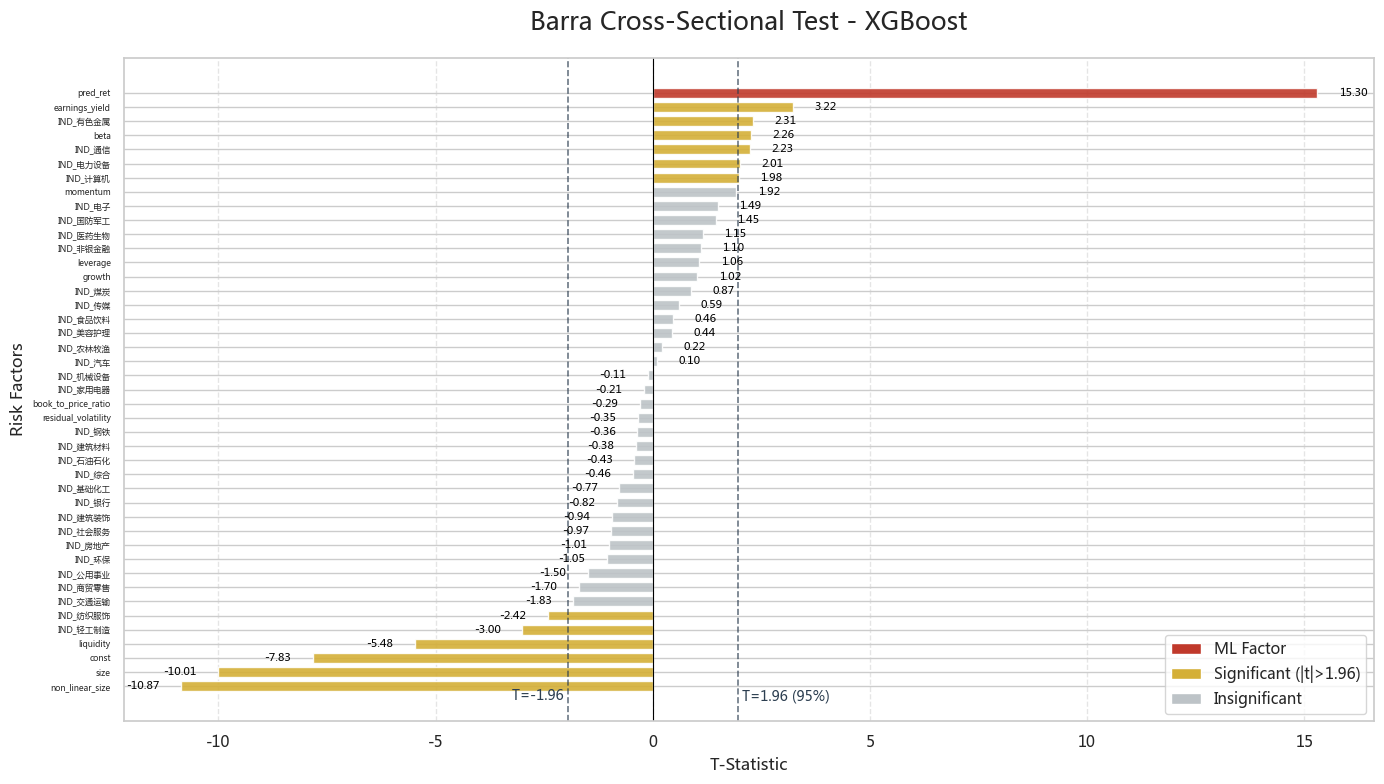

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==========================================
# XGBoost 截面回归显著性 (单图)
# ==========================================

if "display_df_xgb" not in globals():
    raise RuntimeError("请先运行上方 XGBoost 回归单元，生成 display_df_xgb 后再执行本单元。")

plot_data = display_df_xgb.sort_values(by="T-Statistic", ascending=True)

sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Microsoft YaHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['font.family'] = ['PingFang SC', 'Microsoft YaHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.figure(figsize=(14, 8), dpi=100)

colors = []
for factor in plot_data["Factor"]:
    if factor == "pred_ret":
        colors.append("#C0392B")  # deeper red for ML
    elif abs(plot_data.loc[plot_data["Factor"] == factor, "T-Statistic"].values[0]) > 1.96:
        colors.append("#D4AF37")  # gold for significant
    else:
        colors.append("#bdc3c7")

bars = plt.barh(y=plot_data["Factor"], width=plot_data["T-Statistic"], color=colors, alpha=0.9, height=0.7)

plt.axvline(x=1.96, color="#2c3e50", linestyle="--", linewidth=1.2, alpha=0.7)
plt.axvline(x=-1.96, color="#2c3e50", linestyle="--", linewidth=1.2, alpha=0.7)
plt.axvline(x=0, color="black", linewidth=0.8)

plt.text(1.96, -1, " T=1.96 (95%)", color="#2c3e50", fontsize=10, fontweight="bold")
plt.text(-1.96, -1, "T=-1.96 ", color="#2c3e50", fontsize=10, fontweight="bold", ha="right")

for bar in bars:
    width = bar.get_width()
    x_pos = width + (0.5 if width > 0 else -0.5)
    ha = "left" if width > 0 else "right"
    fw = "bold" if bar.get_fc() == "#C0392B" else "normal"
    plt.text(x_pos, bar.get_y() + bar.get_height() / 2, f"{width:.2f}", va="center", ha=ha, fontsize=8, fontweight=fw, color="black")

plt.title("Barra Cross-Sectional Test - XGBoost", fontsize=18, fontweight="bold", pad=20)
plt.xlabel("T-Statistic", fontsize=12)
plt.ylabel("Risk Factors", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.yticks(fontsize=6)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#C0392B", label="ML Factor"),
    Patch(facecolor="#D4AF37", label="Significant (|t|>1.96)"),
    Patch(facecolor="#bdc3c7", label="Insignificant")
]
plt.legend(handles=legend_elements, loc="lower right", fontsize=11)

plt.tight_layout()
save_path = "Barra_Cross_Sectional_Test_XGBoost.pdf"
plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [32]:
import pandas as pd
all_predictions = pd.read_parquet('predictions_with_index.parquet', engine='fastparquet')
# ==========================================
# 最终修复版：Barra + 申万行业中性化 截面回归 (RF)
# ==========================================
import statsmodels.api as sm
from scipy import stats
import numpy as np

print(f"{'='*20} 开始 Barra 截面回归检验 - RF {'='*20}")

# 1. 读取数据
df_shenwan_industry = pd.read_excel('industry.xlsx', engine='openpyxl')
df_shenwan_industry = df_shenwan_industry.rename(columns={'ts_code': 'stkcd'})

df_barra = pd.read_csv('全A股月度cne5数据_2007-2025.csv')
# 日期强制对齐到月末
df_barra['date'] = pd.to_datetime(df_barra['date']) + pd.offsets.MonthEnd(0)
all_predictions['date'] = pd.to_datetime(all_predictions['date']) + pd.offsets.MonthEnd(0)

# 2. 数据准备 (白名单机制)
df_shenwan_industry_clean = df_shenwan_industry[['stkcd', 'industry1']]

style_factors = [
    'size', 'beta', 'momentum', 'residual_volatility', 'non_linear_size',
    'book_to_price_ratio', 'liquidity', 'earnings_yield', 'growth', 'leverage'
]
valid_style_factors = [c for c in style_factors if c in df_barra.columns]
df_barra_clean = df_barra[['date', 'stkcd'] + valid_style_factors]

print("正在合并数据...")
barra_data = pd.merge(
    all_predictions[['date', 'stkcd', 'pred_ret', 'next_ret']],
    df_barra_clean,
    on=['date', 'stkcd'],
    how='inner'
 )
barra_data = pd.merge(barra_data, df_shenwan_industry_clean, on='stkcd', how='left')
if len(barra_data) == 0:
    raise ValueError("合并后数据为空！请检查日期或代码格式。")

print("正在生成行业哑变量 (强制数值化)...")
barra_data['industry1'] = barra_data['industry1'].fillna('Unknown')
barra_data = pd.get_dummies(barra_data, columns=['industry1'], prefix='IND', drop_first=True, dtype=int)
industry_cols = [c for c in barra_data.columns if c.startswith('IND_')]
X_columns = ['pred_ret'] + valid_style_factors + industry_cols
for col in X_columns:
    barra_data[col] = pd.to_numeric(barra_data[col], errors='coerce')

def cross_sectional_regression_safe(group):
    data = group.dropna(subset=['next_ret'] + X_columns)
    if len(data) < len(X_columns) + 10:
        return None
    Y = data['next_ret']
    X = data[X_columns]
    X = sm.add_constant(X)
    try:
        model = sm.OLS(Y, X).fit()
        return model.params
    except:
        return None

print(f"正在逐月回归 (因子总数: {len(X_columns)})...")
monthly_gammas = barra_data.groupby('date').apply(cross_sectional_regression_safe)

barra_summary = pd.DataFrame({
    'Factor': monthly_gammas.columns,
    'Gamma_Mean': monthly_gammas.mean(),
    'T-Statistic': float('nan')
})
for col in monthly_gammas.columns:
    series = monthly_gammas[col].dropna()
    if len(series) > 2:
        t_stat, _ = stats.ttest_1samp(series, 0)
        barra_summary.loc[barra_summary['Factor'] == col, 'T-Statistic'] = t_stat

barra_summary['Abs_T'] = barra_summary['T-Statistic'].abs()
display_df_rf = barra_summary.sort_values(by='Abs_T', ascending=False).drop(columns=['Abs_T'])

print(f"\n>>> Barra + 行业中性化 完整回归结果 (RF, 共 {len(display_df_rf)} 个因子):")
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_rows', None)
from IPython.display import display
display(display_df_rf)

if 'pred_ret' in barra_summary['Factor'].values:
    ml_t = barra_summary.loc[barra_summary['Factor'] == 'pred_ret', 'T-Statistic'].values[0]
    print(f"\n>>> 核心结论: 控制行业和Barra风格后，ML因子的 t值为 {ml_t:.2f}")
    if abs(ml_t) > 1.96:
        print("   [显著] 完美！策略拥有纯粹的选股 Alpha。")
    else:
        print("   [不显著] 策略收益主要来源于风格暴露或行业轮动。")
else:
    print("错误：回归结果中依然没有 pred_ret，可能因为样本不足导致回归全部失败。")

==================== 开始 Barra 截面回归检验 - RF ====================
正在合并数据...
正在合并数据...
正在生成行业哑变量 (强制数值化)...
正在逐月回归 (因子总数: 42)...
正在生成行业哑变量 (强制数值化)...
正在逐月回归 (因子总数: 42)...

>>> Barra + 行业中性化 完整回归结果 (RF, 共 43 个因子):

>>> Barra + 行业中性化 完整回归结果 (RF, 共 43 个因子):


/var/folders/3v/qp1m5cd16l5dgvqp5zlpv9rh0000gn/T/ipykernel_91737/399081240.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_gammas = barra_data.groupby('date').apply(cross_sectional_regression_safe)


,Factor,Gamma_Mean,T-Statistic
pred_ret,pred_ret,0.2271,20.9900
const,const,-0.1050,-14.9796
non_linear_size,non_linear_size,-0.0072,-7.8358
size,size,-0.0118,-7.7885
liquidity,liquidity,-0.0044,-4.1043
earnings_yield,earnings_yield,0.0021,3.3808
IND_通信,IND_通信,0.0094,2.8255
IND_有色金属,IND_有色金属,0.0098,2.7146
IND_计算机,IND_计算机,0.0085,2.6665
IND_电力设备,IND_电力设备,0.0072,2.6001



>>> 核心结论: 控制行业和Barra风格后，ML因子的 t值为 20.99
   [显著] 完美！策略拥有纯粹的选股 Alpha。


findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Fon

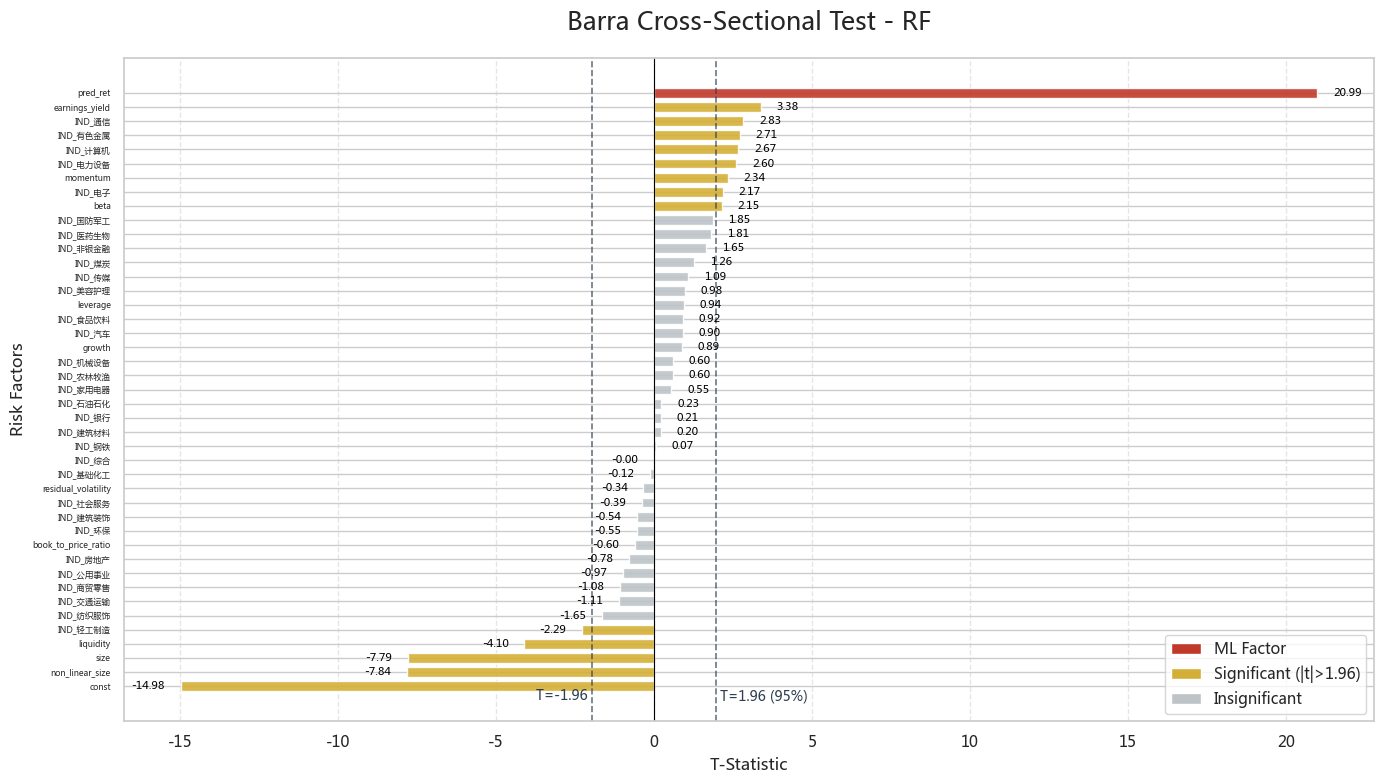

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==========================================
# RF 截面回归显著性 (单图)
# ==========================================

if "display_df_rf" not in globals():
    raise RuntimeError("请先运行上方 RF 回归单元，生成 display_df_rf 后再执行本单元。")

plot_data = display_df_rf.sort_values(by="T-Statistic", ascending=True)

sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Microsoft YaHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['font.family'] = ['PingFang SC', 'Microsoft YaHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.figure(figsize=(14, 8), dpi=100)

colors = []
for factor in plot_data["Factor"]:
    if factor == "pred_ret":
        colors.append("#C0392B")  # deeper red for ML
    elif abs(plot_data.loc[plot_data["Factor"] == factor, "T-Statistic"].values[0]) > 1.96:
        colors.append("#D4AF37")  # gold for significant
    else:
        colors.append("#bdc3c7")

bars = plt.barh(y=plot_data["Factor"], width=plot_data["T-Statistic"], color=colors, alpha=0.9, height=0.7)

plt.axvline(x=1.96, color="#2c3e50", linestyle="--", linewidth=1.2, alpha=0.7)
plt.axvline(x=-1.96, color="#2c3e50", linestyle="--", linewidth=1.2, alpha=0.7)
plt.axvline(x=0, color="black", linewidth=0.8)

plt.text(1.96, -1, " T=1.96 (95%)", color="#2c3e50", fontsize=10, fontweight="bold")
plt.text(-1.96, -1, "T=-1.96 ", color="#2c3e50", fontsize=10, fontweight="bold", ha="right")

for bar in bars:
    width = bar.get_width()
    x_pos = width + (0.5 if width > 0 else -0.5)
    ha = "left" if width > 0 else "right"
    fw = "bold" if bar.get_fc() == "#C0392B" else "normal"
    plt.text(x_pos, bar.get_y() + bar.get_height() / 2, f"{width:.2f}", va="center", ha=ha, fontsize=8, fontweight=fw, color="black")

plt.title("Barra Cross-Sectional Test - RF", fontsize=18, fontweight="bold", pad=20)
plt.xlabel("T-Statistic", fontsize=12)
plt.ylabel("Risk Factors", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.yticks(fontsize=6)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#C0392B", label="ML Factor"),
    Patch(facecolor="#D4AF37", label="Significant (|t|>1.96)"),
    Patch(facecolor="#bdc3c7", label="Insignificant")
]
plt.legend(handles=legend_elements, loc="lower right", fontsize=11)

plt.tight_layout()
save_path = "Barra_Cross_Sectional_Test_RF.pdf"
plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
plt.show()

findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Font family 'PingFang SC' not found.
findfont: Fon

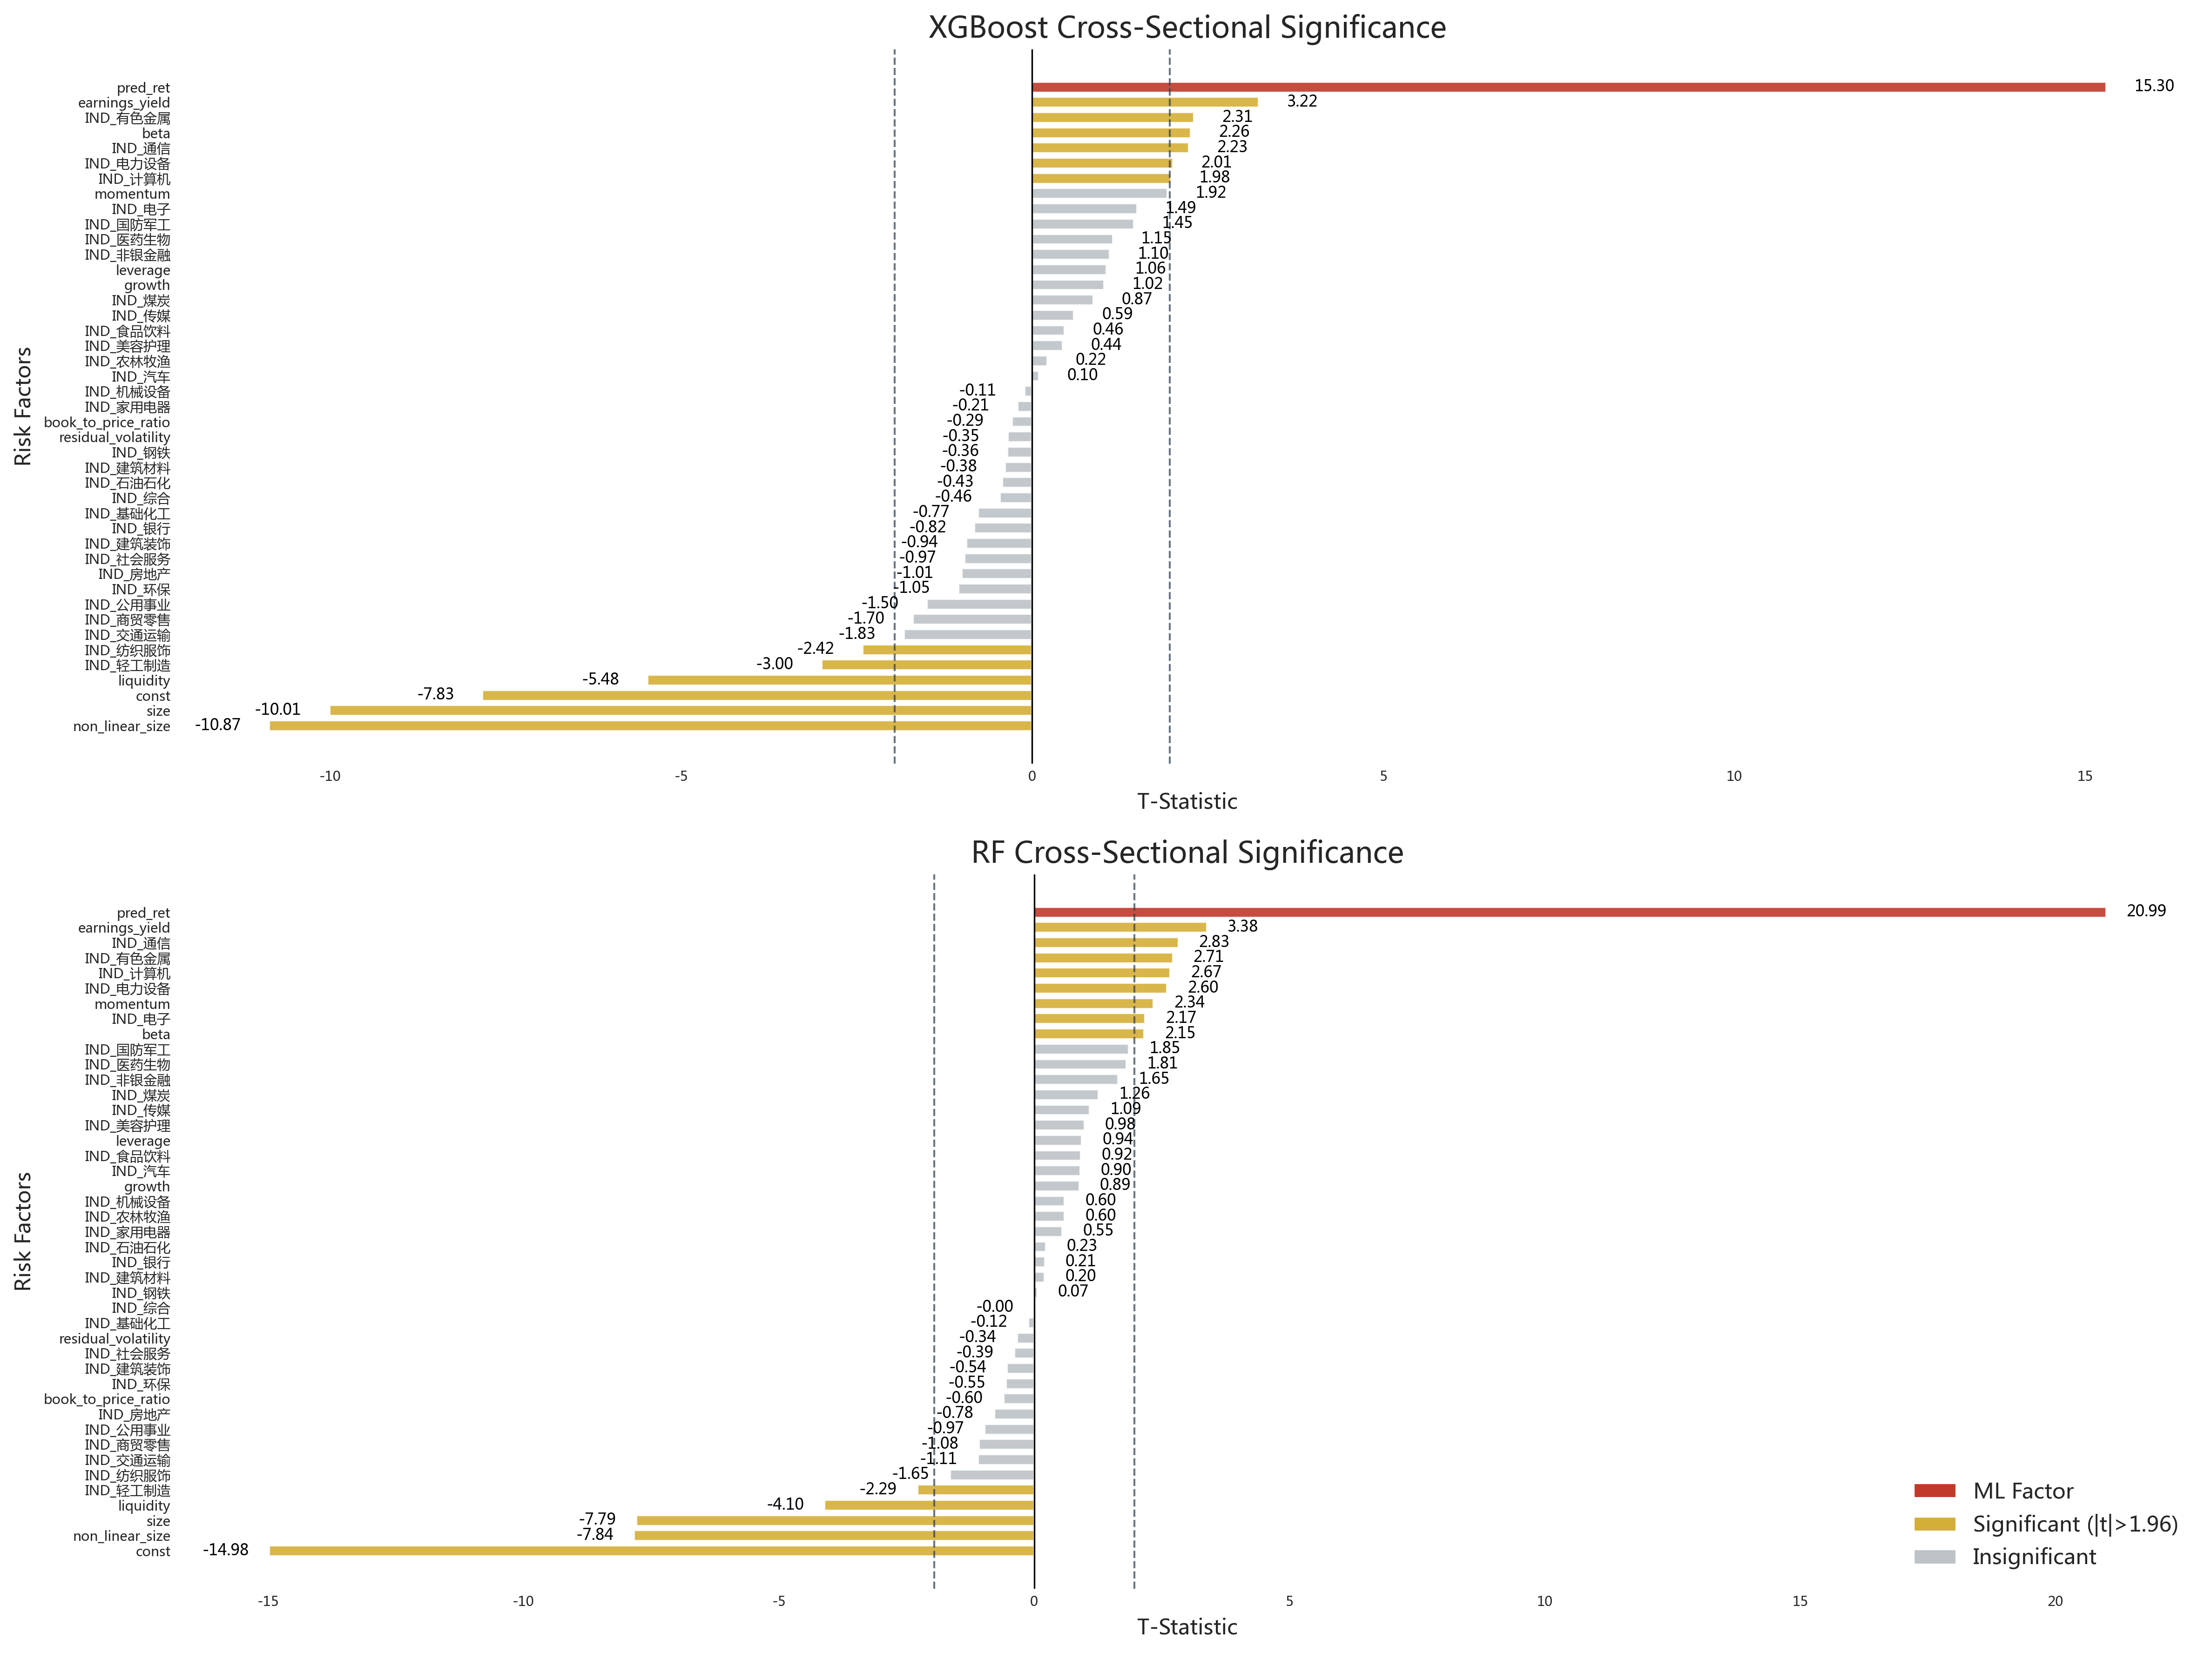

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# 使用前面绘图单元生成的结果
if "display_df_xgb" not in globals() or "display_df_rf" not in globals():
    raise RuntimeError("请先运行单元 7 (XGBoost 图) 和单元 9 (RF 图)，生成 display_df_xgb 与 display_df_rf 后再执行此单元。")

sns.set_style("white")
plt.rcParams["savefig.transparent"] = True
plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Microsoft YaHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['font.family'] = ['PingFang SC', 'Microsoft YaHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig, axes = plt.subplots(2, 1, figsize=(16, 12), dpi=300)
fig.patch.set_alpha(0)

def _plot_panel(ax, df, title):
    plot_data = df.sort_values(by="T-Statistic", ascending=True)
    colors = []
    for factor, tval in zip(plot_data["Factor"], plot_data["T-Statistic"]):
        if factor == "pred_ret":
            colors.append("#C0392B")  # deeper red for ML
        elif abs(tval) > 1.96:
            colors.append("#D4AF37")  # gold for significant
        else:
            colors.append("#bdc3c7")
    bars = ax.barh(y=plot_data["Factor"], width=plot_data["T-Statistic"], color=colors, alpha=0.9, height=0.7)
    ax.axvline(x=1.96, color="#2c3e50", linestyle="--", linewidth=1.0, alpha=0.7)
    ax.axvline(x=-1.96, color="#2c3e50", linestyle="--", linewidth=1.0, alpha=0.7)
    ax.axvline(x=0, color="black", linewidth=0.8)
    for bar, factor, tval in zip(bars, plot_data["Factor"], plot_data["T-Statistic"]):
        width = bar.get_width()
        x_pos = width + (0.4 if width > 0 else -0.4)
        ha = "left" if width > 0 else "right"
        fw = "bold" if factor == "pred_ret" else "normal"
        ax.text(x_pos, bar.get_y() + bar.get_height() / 2, f"{width:.2f}", va="center", ha=ha, fontsize=8, fontweight=fw, color="black")
    ax.set_title(title, fontsize=15, fontweight="bold")
    ax.set_xlabel("T-Statistic", fontsize=11)
    ax.set_ylabel("Risk Factors", fontsize=11)
    ax.grid(False)
    ax.set_facecolor("none")
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(axis="both", which="both", length=0, labelsize=7)

_plot_panel(axes[0], display_df_xgb, "XGBoost Cross-Sectional Significance")
_plot_panel(axes[1], display_df_rf, "RF Cross-Sectional Significance")

legend_elements = [
    Patch(facecolor="#C0392B", label="ML Factor"),
    Patch(facecolor="#D4AF37", label="Significant (|t|>1.96)"),
    Patch(facecolor="#bdc3c7", label="Insignificant")
]
axes[1].legend(handles=legend_elements, loc="lower right", fontsize=11, frameon=False)
plt.tight_layout()
save_path = "Barra_Cross_Sectional_Significance_Comparison.pdf"
plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
plt.show()